In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights
from tqdm import tqdm  # For progress bars
from PIL import ImageDraw
import random

# Read Dataset

In [2]:
# Data directory
data_dir = "/kaggle/input/dog-and-cat-detection"
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

df.head()

,image_name
0,Cats_Test3283.png
1,Cats_Test727.png
2,Cats_Test1584.png
3,Cats_Test1196.png
4,Cats_Test2587.png


# Create PyTorch Dataset

In [3]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) <= 1:
                    valid_image_files.append(img_name)
                else:
                    print(
                        f"Image {img_name} has multiple objects and will be excluded from the dataset"
                    )
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)
    
        annotation_name = os.path.splitext(img1_file)[0] + ".xml"
        img1_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )
    
        idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)
    
        annotation_name = os.path.splitext(img2_file)[0] + ".xml"
        img2_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )
    
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")
    
        # Horizontal merge
        merged_image = Image.new(
            "RGB", (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)
    
        merged_annotations = []
    
        # Adjust bbox coordinates for objects from img1 AND normalize
        new_bbox = [
            img1_annotations[1][0] * img1.width / merged_w,  # Normalize xmin
            img1_annotations[1][1] * img1.height / merged_h,                # Normalize ymin
            img1_annotations[1][2] * img1.width / merged_w,  # Normalize xmax
            img1_annotations[1][3] * img1.height / merged_h,                # Normalize ymax
        ]
        
        merged_annotations.append(
            {"bbox": new_bbox, "label": img1_annotations[0]}
        )
        
        # Adjust bbox coordinates for objects from img2 AND normalize
        new_bbox = [
            (img2_annotations[1][0] * img2.width + img1.width) / merged_w,  # Normalize xmin
            img2_annotations[1][1] * img2.height / merged_h,                # Normalize ymin
            (img2_annotations[1][2] * img2.width + img1.width) / merged_w,  # Normalize xmax
            img2_annotations[1][3] * img2.height / merged_h,                # Normalize ymax
        ]
        
        merged_annotations.append({"bbox": new_bbox, "label": img2_annotations[0]})
        
        # Convert merged image to tensor
        if self.transform:
            merged_image = self.transform(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)
        
        # Convert annotations to 1D tensors, with shape (4,) for bbox and (1,) for label
        annotations = torch.zeros((len(merged_annotations), 5))
        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat((torch.tensor(ann["bbox"]), torch.tensor([ann["label"]])))
        
        return merged_image, annotations


    
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
    
        # Get image size for normalization
        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)
    
        label = None
        bbox = None
        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:  # Take the first label
                label = name
                # Get bounding box coordinates
                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)
    
                # Normalize bbox coordinates to [0, 1]
                bbox = [
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height,
                ]
    
        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1
    
        return label_num, torch.tensor(bbox, dtype=torch.float32)

In [4]:
# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

Image Cats_Test736.png has multiple objects and will be excluded from the dataset
Image Cats_Test736.png has multiple objects and will be excluded from the dataset


In [5]:
# Example: Check the shape of one training sample
img, ann = train_dataset[0]
print("Training dataset length:", len(train_dataset))
print("Image shape:", img.shape)   # [C, H, W]
print("Annotations:", ann)

# Example: Check the shape of one validation sample
img, ann = val_dataset[0]
print("Validation dataset length:", len(val_dataset))
print("Image shape:", img.shape)   # [C, H, W]
print("Annotations:", ann)


Training dataset length: 2947
Image shape: torch.Size([3, 224, 224])
Annotations: tensor([[0.0820, 0.1040, 0.2610, 0.5760, 0.0000],
        [0.6730, 0.1973, 0.8140, 0.5787, 1.0000]])
Validation dataset length: 738
Image shape: torch.Size([3, 224, 224])
Annotations: tensor([[0.1124, 0.1140, 0.3433, 0.6300, 1.0000],
        [0.7106, 0.1380, 0.8801, 0.3900, 1.0000]])


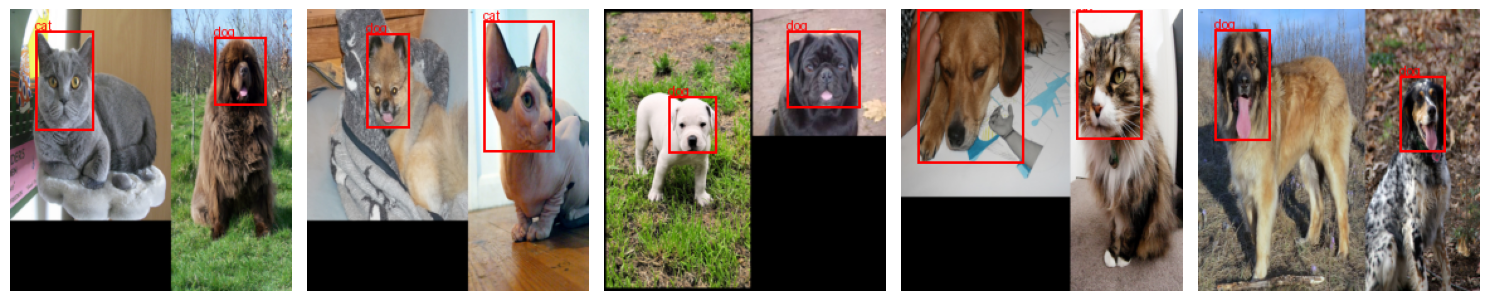

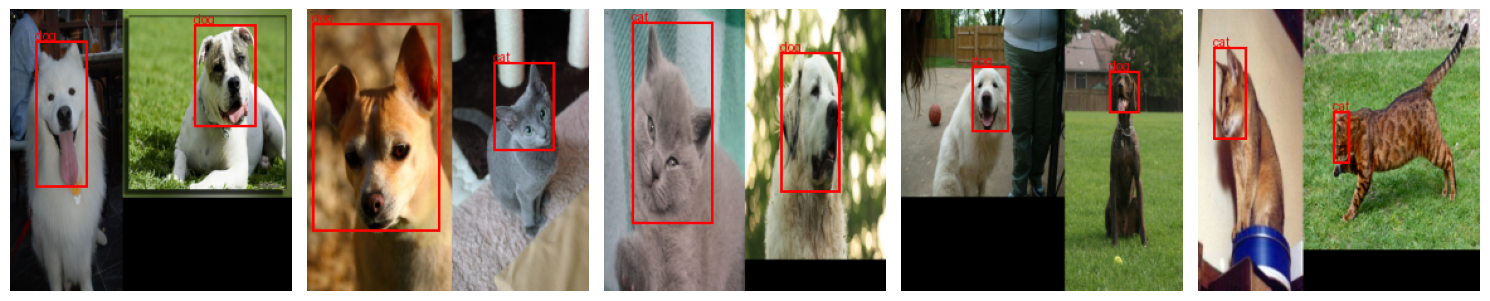

In [6]:
def denormalize(tensor, mean, std):
    """
    Denormalize a tensor image with mean and std.
    """
    mean = torch.tensor(mean).reshape(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

def show_images(dataset, num_images=5, show_bbox=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img, annotations = dataset[i]  # img: tensor, annotations: (N, 5)
        img = denormalize(img, mean, std)
        img = torch.clamp(img, 0, 1)
        img_pil = TF.to_pil_image(img)

        width, height = img_pil.size
        draw = ImageDraw.Draw(img_pil)

        if show_bbox:
            for ann in annotations:
                bbox = ann[:4]
                label = int(ann[4])
                xmin = int(bbox[0] * width)
                ymin = int(bbox[1] * height)
                xmax = int(bbox[2] * width)
                ymax = int(bbox[3] * height)
                draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
                draw.text((xmin, ymin - 10), f"{'cat' if label == 0 else 'dog' if label == 1 else 'unknown'}", fill="red")

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_pil)
        plt.axis("off")

    plt.tight_layout()
    plt.show()



show_images(train_dataset)
show_images(val_dataset)

# Create DataLoader

In [7]:
batch_size = 128

In [8]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Get one batch from the train loader
for images, annotations in train_loader:
    print("Train batch - images shape:", images.shape)          # [B, C, H, W]
    print("Train batch - annotations shape:", annotations.shape)  # [B, 2, 5]
    break  # Only print first batch

# Get one batch from the val loader
for images, annotations in val_loader:
    print("Val batch - images shape:", images.shape)
    print("Val batch - annotations shape:", annotations.shape)
    break


Train batch - images shape: torch.Size([128, 3, 224, 224])
Train batch - annotations shape: torch.Size([128, 2, 5])
Val batch - images shape: torch.Size([128, 3, 224, 224])
Val batch - annotations shape: torch.Size([128, 2, 5])


# Create Model

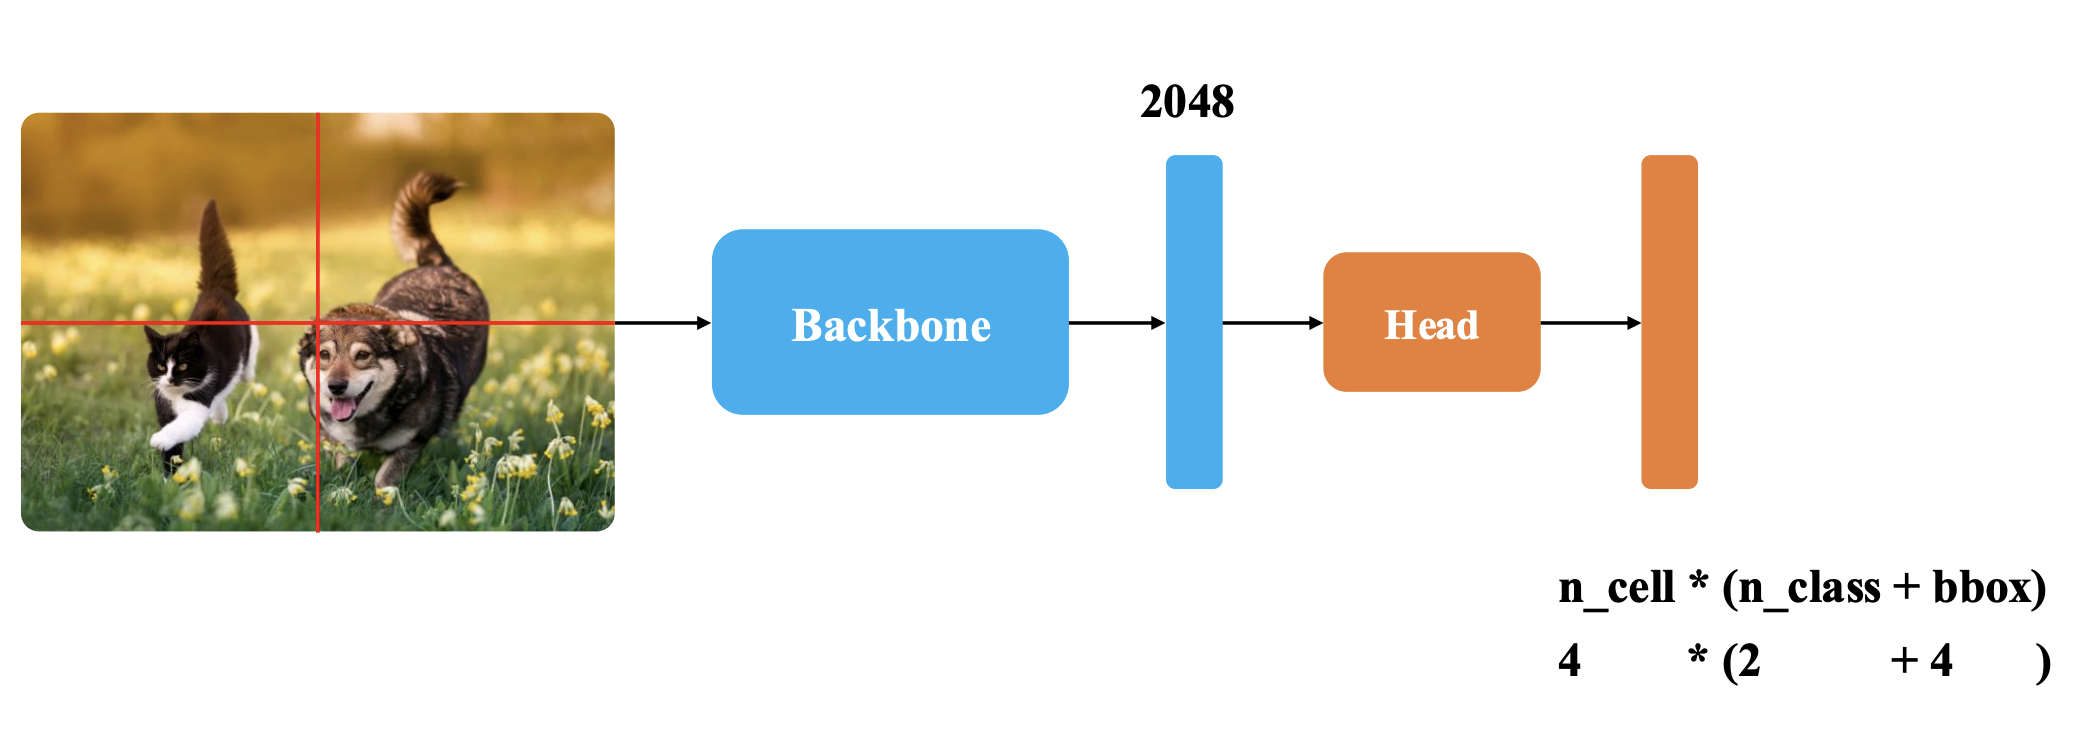

In [10]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        # Remove the final classification layer of ResNet
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add the YOLO head
        self.fcs = nn.Linear(
            2048, 2 * 2 * (4 + self.num_classes)
        )  # 2 is for the number of grid cell

    def forward(self, x):
        # x shape: (batch_size, C, H, W)
        features = self.backbone(x)
        features = F.adaptive_avg_pool2d(features, (1, 1))  # shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)      # shape: (batch_size, 2048)
        features = self.fcs(features)

        return features

# Training and Evaluation

In [11]:
def calculate_loss(output, targets, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    batch_size = output.shape[0]
    total_loss = 0

    output = output.view(batch_size, 2, 2, 4 + num_classes)  # Reshape to (batch_size, grid_y, grid_x, 4 + num_classes)

    for i in range(batch_size):  # Iterate through each image in the batch
        for j in range(len(targets[i])):  # Iterate through objects in the image

            # Determine which grid cell the object's center falls into
            # Assuming bbox coordinates are normalized to [0, 1]
            bbox_center_x = (targets[i][j][0] + targets[i][j][2]) / 2
            bbox_center_y = (targets[i][j][1] + targets[i][j][3]) / 2

            grid_x = int(bbox_center_x * 2)  # Multiply by number of grid cells (2 in this case)
            grid_y = int(bbox_center_y * 2)

            # 1. Classification Loss for the responsible grid cell
            # Convert label to one-hot encoding only for this example
            # One hot encoding
            label_one_hot = torch.zeros(num_classes, device=device)
            label_one_hot[int(targets[i][j][4])] = 1

            # Classification loss (using CrossEntropyLoss)
            classification_loss = ce_loss(output[i, grid_y, grid_x, 4:], label_one_hot)

            # 2. Regression Loss for the responsible grid cell
            bbox_target = targets[i][j][:4].to(device)
            regression_loss = mse_loss(output[i, grid_y, grid_x, :4], bbox_target)

            # 3. No Object Loss (for other grid cells)
            no_obj_loss = 0
            for other_grid_y in range(2):
                for other_grid_x in range(2):
                    if other_grid_y != grid_y or other_grid_x != grid_x:
                        # MSE loss for predicting no object (all zeros)
                        no_obj_loss += mse_loss(output[i, other_grid_y, other_grid_x, :4], torch.zeros(4, device=device))

            total_loss += classification_loss + regression_loss + no_obj_loss

    return total_loss / batch_size  # Average loss over the batch


In [12]:
def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validation", leave=False):
            images = images.to(device)

            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)
            running_loss += total_loss.item()

            # Reshape output to (batch_size, grid_y, grid_x, 4 + num_classes)
            output = output.view(images.shape[0], 2, 2, 4 + num_classes)

            # Collect predictions and targets for Accuracy calculation
            for batch_idx in range(images.shape[0]):
                for target in targets[batch_idx]:
                    # Determine responsible grid cell
                    bbox_center_x = (target[0] + target[2]) / 2
                    bbox_center_y = (target[1] + target[3]) / 2
                    grid_x = int(bbox_center_x * 2)
                    grid_y = int(bbox_center_y * 2)

                    # Class prediction (index of max probability)
                    prediction = output[batch_idx, grid_y, grid_x, 4:].argmax().item()
                    all_predictions.append(prediction)

                    all_targets.append(target[4].item())

    val_loss = running_loss / len(data_loader)

    # Convert lists to tensors for PyTorch’s metric functions
    all_predictions = torch.tensor(all_predictions, device=device)
    all_targets = torch.tensor(all_targets, device=device)

    # Calculate accuracy
    val_accuracy = (all_predictions == all_targets).float().mean().item()

    return val_loss, val_accuracy


In [13]:
def train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes
):
    best_val_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        running_loss = 0.0

        for images, targets in tqdm(train_loader, desc="Batches", leave=False):
            images = images.to(device)

            optimizer.zero_grad()
            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
# Model
model = SimpleYOLO()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_classes = 2
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s] 
Batches: 100%|██████████| 24/24 [01:34<00:00,  2.67s/it]
                                                        
Batches: 100%|██████████| 24/24 [01:14<00:00,  2.29s/it]
                                                        
Batches: 100%|██████████| 24/24 [01:14<00:00,  2.27s/it]
                                                        
Batches: 100%|██████████| 24/24 [01:14<00:00,  2.30s/it]
                                                        
Batches: 100%|██████████| 24/24 [01:14<00:00,  2.32s/it]
                                                        
Batches: 100%|██████████| 24/24 [01:14<00:00,  2.28s/it]
                                                        
Batches: 100%|██████████| 24/24 [01:13<00:00,  2.26s/it]
                                                        
Batches: 100%|██

([1.1136807675162952,
  0.5177946574985981,
  0.3972233546276887,
  0.35900972473124665,
  0.3623989559710026,
  0.6118730033437411,
  0.3802175186574459,
  0.33649150157968205,
  0.314824807147185,
  0.35469238460063934],
 [1.6480160156885784,
  0.6165432532628378,
  0.7486680448055267,
  0.6259225308895111,
  1.659425715605418,
  0.8133780856927236,
  0.6574217677116394,
  0.5655741443236669,
  0.6280228197574615,
  1.329445719718933],
 [],
 [0.8678861856460571,
  0.9397019147872925,
  0.9119241237640381,
  0.9539295434951782,
  0.803523063659668,
  0.9071815609931946,
  0.9430894255638123,
  0.9607046246528625,
  0.9512195587158203,
  0.86720871925354])

# Inference

ValueError: y1 must be greater than or equal to y0

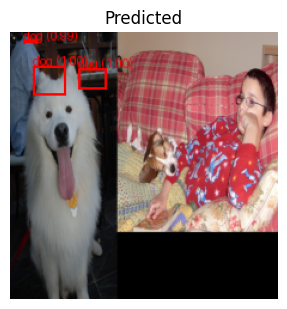

In [15]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from PIL import ImageDraw
import torch.nn.functional as F

model.load_state_dict(torch.load("best_model.pth", map_location=device))

# Ensure model is in eval mode
model.eval()

# Class label mapping
idx_to_class = {0: 'cat', 1: 'dog'}

# Mean and std used in transforms (for denormalization)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

# Inference on 5 validation images
plt.figure(figsize=(20, 8))
for i in range(5):
    image, annotations = val_dataset[i]
    input_tensor = image.unsqueeze(0).to(device)  # [1, C, H, W]

    with torch.no_grad():
        output = model(input_tensor)  # [1, 2*2*(4+num_classes)]
        output = output.view(1, 2, 2, 4 + model.num_classes)  # [1, 2, 2, 4 + num_classes]

    output = output.squeeze(0).cpu()  # [2, 2, 4 + num_classes]

    # Denormalize image
    image = denormalize(image, mean, std)
    image = torch.clamp(image, 0, 1)
    img_pil = TF.to_pil_image(image)
    draw = ImageDraw.Draw(img_pil)
    W, H = img_pil.size

    # Go through each of the 2x2 grid cells
    for gy in range(2):
        for gx in range(2):
            cell_output = output[gy, gx]  # [4 + num_classes]
            bbox = cell_output[:4].numpy()  # [xmin, ymin, xmax, ymax], normalized
            class_logits = cell_output[4:]
            pred_class = class_logits.argmax().item()
            score = F.softmax(class_logits, dim=0)[pred_class].item()

            if score > 0.5:  # Optional: confidence threshold
                xmin = int(bbox[0] * W)
                ymin = int(bbox[1] * H)
                xmax = int(bbox[2] * W)
                ymax = int(bbox[3] * H)
                draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
                draw.text((xmin, ymin - 10), f"{idx_to_class.get(pred_class, 'unk')} ({score:.2f})", fill="red")

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pil)
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()